# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Proyecto Integrador**

### Tecnológico de Monterrey


## **Actividad de la Semana 02**
### **EDA de los conjuntos de datos seleccionados**


Equipo 32

José Adan Vega Pérez [A01796093]

Silvia Xochitl Ibañez Vara [A01795200]

Diego Andrés Bernal Díaz [A01795975]



## Requisitos

igraph para procesar analisis de grafos en C, en lugar de networkx

In [21]:
!pip install igraph

pytorch y pytorch - geometric para conseguir los datasets FB15k-237 y WN18RR

In [22]:
import torch

print("Torch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
print("Versión CUDA:", torch.version.cuda)

assert torch.cuda.is_available(), ("No GPU. Set Runtime → Change runtime type → GPU")

Torch: 2.9.0+cu126
CUDA disponible: True
Versión CUDA: 12.6


In [23]:
import torch

try:
    import torch_geometric
except ModuleNotFoundError:
    torch_version = torch.__version__.split("+")[0]
    cuda_version = torch.version.cuda.replace(".", "")

    !pip install -q pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv \
        -f https://data.pyg.org/whl/torch-{torch_version}+cu{cuda_version}.html

    !pip install -q torch-geometric


In [24]:
import torch
import torch_geometric

print("Torch:", torch.__version__)
print("Torch Geometric:", torch_geometric.__version__)


Torch: 2.9.0+cu126
Torch Geometric: 2.7.0


In [25]:
from pathlib import Path

# Rutas base
PYG_DIR = Path("./pyg_temp")     # Carpeta temporal para descargas de PyG
FINAL_DATA_DIR = Path("./data")  # Carpeta de datos principal

# Crear carpetas si no existen (idempotente)
for directory in [PYG_DIR, FINAL_DATA_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print("Estructura de carpetas verificada:")
print(f"- PYG_DIR: {PYG_DIR.resolve()}")
print(f"- FINAL_DATA_DIR: {FINAL_DATA_DIR.resolve()}")


Estructura de carpetas verificada:
- PYG_DIR: /content/pyg_temp
- FINAL_DATA_DIR: /content/data


## Obtencion de los datasets Wordnet18 y Freebase 15k de pytorch-geometric

In [26]:
import os
import shutil
import pandas as pd
from torch_geometric.datasets import WordNet18RR, FB15k_237

# --- CONFIGURACIÓN ---
PYG_DIR = "./pyg_temp"  # Carpeta temporal para descargas de PyG
FINAL_DATA_DIR = "./data" # Tu carpeta de datos principal

def standard_to_txt(pyg_dataset, dataset_name):
    """
    Toma los archivos raw descargados por PyG y los mueve a tu carpeta ./data
    en formato limpio (head, relation, tail).
    """
    raw_dir = pyg_dataset.raw_dir
    target_dir = os.path.join(FINAL_DATA_DIR, dataset_name)
    os.makedirs(target_dir, exist_ok=True)

    print(f"\nProcesando {dataset_name} desde {raw_dir}...")

    # Mapeo de nombres de archivos de PyG a nombres estándar
    # PyG a veces usa 'train.txt', a veces otros nombres.
    files_map = {
        'train': ['train.txt'],
        'valid': ['valid.txt', 'valid.csv'],
        'test': ['test.txt']
    }

    for split, possible_names in files_map.items():
        found = False
        for fname in possible_names:
            src_path = os.path.join(raw_dir, fname)
            if os.path.exists(src_path):
                found = True
                dst_path = os.path.join(target_dir, f"{split}.txt")

                # Leemos con Pandas para asegurarnos de limpiar headers o índices extra
                try:
                    # FB15k-237 y WN18RR raw suelen venir separados por tabs o espacios
                    df = pd.read_csv(src_path, sep=None, engine='python', header=None, on_bad_lines='skip')

                    # Quedarnos con las primeras 3 columnas (Head, Rel, Tail)
                    # OJO: FB15k-237 a veces viene como (Head, Tail, Rel) o (Head, Rel, Tail)
                    # En los raw files de PyG estándar suele ser: Head, Relation, Tail (Strings)
                    if df.shape[1] >= 3:
                        df = df.iloc[:, :3]

                        # Guardamos en formato limpio separado por comas o tabs
                        df.to_csv(dst_path, sep=',', index=False, header=False)
                        print(f"  -> {split}.txt guardado en {target_dir} ({len(df)} filas)")
                    else:
                        print(f"  [!] Estructura extraña en {fname}: {df.shape}")

                except Exception as e:
                    print(f"  [Error] al procesar {fname}: {e}")
                break

        if not found:
            print(f"  [X] No se encontró archivo para split '{split}'")

# --- 1. DESCARGAR WN18RR ---
print("--- Descargando WordNet18RR usando PyG ---")
# Esto descargará automáticamente los archivos a ./pyg_temp/WordNet18RR/raw
dataset_wn = WordNet18RR(root=os.path.join(PYG_DIR, "WordNet18RR"))
standard_to_txt(dataset_wn, "WN18RR")

# --- 2. DESCARGAR FB15k-237 ---
print("--- Descargando FB15k-237 usando PyG ---")
# Esto descargará automáticamente los archivos a ./pyg_temp/FB15k_237/raw
dataset_fb = FB15k_237(root=os.path.join(PYG_DIR, "FB15k-237"))
standard_to_txt(dataset_fb, "FB15k-237")

print("\n--- ¡LISTO! ---")
print(f"Ahora tienes WN18RR y FB15k-237 en la carpeta '{FINAL_DATA_DIR}' con el mismo formato que el resto.")

--- Descargando WordNet18RR usando PyG ---

Procesando WN18RR desde pyg_temp/WordNet18RR/raw...
  -> train.txt guardado en ./data/WN18RR (86835 filas)
  -> valid.txt guardado en ./data/WN18RR (3034 filas)
  -> test.txt guardado en ./data/WN18RR (3134 filas)
--- Descargando FB15k-237 usando PyG ---

Procesando FB15k-237 desde pyg_temp/FB15k-237/raw...
  -> train.txt guardado en ./data/FB15k-237 (272115 filas)
  -> valid.txt guardado en ./data/FB15k-237 (17535 filas)
  -> test.txt guardado en ./data/FB15k-237 (20466 filas)

--- ¡LISTO! ---
Ahora tienes WN18RR y FB15k-237 en la carpeta './data' con el mismo formato que el resto.


## Obtencion de CoDEx-M, WordNet11, FreeBase13

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests

# Set style for plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# --- CONFIGURATION (CORRECTED URLS) ---
DATA_DIR = "./data"

DATASETS = {
    "CoDEx-M": {
        "base_url": "https://raw.githubusercontent.com/tsafavi/codex/master/data/triples/codex-m/",
        "files": ["train.txt", "valid.txt", "test.txt"]
    },
    "WN11": {
        "base_url": "https://raw.githubusercontent.com/KGCompletion/TransL/master/WN11/",
        "files": ["train.txt", "valid.txt", "test.txt"]
    },
    "FB13": {
        "base_url": "https://raw.githubusercontent.com/KGCompletion/TransL/master/FB13/",
        "files": ["train.txt", "valid.txt", "test.txt"]
    }
}


# --- HELPER FUNCTIONS ---
def download_file(url, save_path):
    """Downloads a file from a URL if it doesn't exist."""
    if not os.path.exists(save_path):
        print(f"Downloading {save_path}...")
        try:
            r = requests.get(url)
            r.raise_for_status()
            with open(save_path, 'wb') as f:
                f.write(r.content)
            print(f"  -> Success!")
        except Exception as e:
            print(f"  -> Failed to download {url}: {e}")
    else:
        print(f"Found local: {save_path}")

def load_dataset(name, config):
    """Loads train/valid/test into a dictionary of DataFrames."""
    path = os.path.join(DATA_DIR, name)
    os.makedirs(path, exist_ok=True)

    dfs = {}
    for file_name in config["files"]:
        # 1. Download
        url = config["base_url"] + file_name
        local_path = os.path.join(path, file_name)
        download_file(url, local_path)

        # 2. Load to Pandas
        # Try-catch to handle potential parsing issues
        try:
            # We use engine='python' and sep=None to auto-detect tab or space separators
            # This makes it robust against different format standards
            df = pd.read_csv(local_path, sep=None, engine='python',
                             names=['head', 'relation', 'tail'],
                             on_bad_lines='skip')

            # Clean up: Sometimes the last column has a 4th value (label 1/-1) in older datasets
            # For EDA we usually just want the triplet. Let's check shape.
            if df.shape[1] > 3:
                df = df.iloc[:, :3]
                df.columns = ['head', 'relation', 'tail']

            dfs[file_name.replace('.txt', '')] = df
        except Exception as e:
            print(f"Error reading {file_name}: {e}")

    return dfs

# --- EXECUTION ---
print("--- STARTING DATA LOADING ---")
kg_data = {}

for ds_name, config in DATASETS.items():
    print(f"\nProcessing {ds_name}...")
    kg_data[ds_name] = load_dataset(ds_name, config)

    # Quick Sanity Check
    if 'train' in kg_data[ds_name]:
        count = len(kg_data[ds_name]['train'])
        print(f"  -> Loaded {ds_name} Train: {count} triplets")
        print(f"  -> Sample: {kg_data[ds_name]['train'].iloc[0].values}")

print("\n--- READY FOR EDA ---")

--- STARTING DATA LOADING ---

Processing CoDEx-M...
Found local: ./data/CoDEx-M/train.txt
Found local: ./data/CoDEx-M/valid.txt
Found local: ./data/CoDEx-M/test.txt
  -> Loaded CoDEx-M Train: 185584 triplets
  -> Sample: ['Q108946' 'P161' 'Q39792']

Processing WN11...
Found local: ./data/WN11/train.txt
Found local: ./data/WN11/valid.txt
Found local: ./data/WN11/test.txt
  -> Loaded WN11 Train: 112581 triplets
  -> Sample: ['__spiritual_bouquet_1' '_type_of' '__sympathy_card_1']

Processing FB13...
Found local: ./data/FB13/train.txt
Found local: ./data/FB13/valid.txt
Found local: ./data/FB13/test.txt
  -> Loaded FB13 Train: 316232 triplets
  -> Sample: ['antoine_brutus_menier' 'religion' 'roman_catholic_church']

--- READY FOR EDA ---


# 1. Estructura de los datos y Macro-Estadisticas

### Caracterización Macro-Estadística de los Datasets

## Conceptos Previos y Justificación

La primera fase del entendimiento de los datos consiste en dimensionar la magnitud y la densidad de los grafos de conocimiento seleccionados. Estas métricas no solo dictan los requisitos computacionales (memoria RAM y GPU), sino que predeterminan la dificultad de la tarea de extrapolación.

Para este análisis, se consideran las siguientes variables clave:

    Entidades (∣E∣) y Relaciones (∣R∣): Representan el tamaño del vocabulario. Un número alto de entidades (como en FB13) exige matrices de embeddings más grandes, mientras que el número de relaciones define la complejidad semántica de las interacciones.

    Grado Promedio (Avg Degree): Calculado como la razón entre el total de tripletas y el número de entidades. Esta es quizás la métrica más crítica para redes neuronales de grafos (GNNs). Un grado alto implica que cada nodo tiene muchos vecinos de los cuales agregar información ("contexto rico"). Un grado bajo implica "escasez de información", dificultando la inferencia de nuevos enlaces.

    Densidad del Grafo: Indica qué tan cerca está el grafo de ser "completo" (donde todos están conectados con todos). En grafos de conocimiento reales, este valor es típicamente muy bajo (dispersión), pero las diferencias de magnitud entre datasets indican cambios drásticos en la topología.

### Expectativa Teórica
Se espera observar una dicotomía clara entre los datasets de origen lingüístico/jerárquico (WordNet) y los de conocimiento general (Freebase). Los primeros deberían comportarse como estructuras tipo árbol (baja densidad y grado), mientras que los segundos deberían mostrar una estructura de red social o "pequeño mundo" (alta conectividad).

Found datasets: ['WN18RR', 'FB15k-237', 'FB13', 'CoDEx-M', 'WN11']


| Dataset   | Entities (&#124;E&#124;) | Relations (&#124;R&#124;) | Triples (Total) | Train   | Valid | Test   | Avg Degree | Graph Density |
|-----------|--------------------------|---------------------------|-----------------|---------|-------|--------|------------|---------------|
| WN18RR    | 40,943                   | 11                        | 93,003          | 86,835  | 3,034 | 3,134  | 2.27       | 0.000055      |
| FB15k-237 | 14,541                   | 237                       | 310,116         | 272,115 | 17,535| 20,466 | 21.33      | 0.001467      |
| FB13      | 75,043                   | 13                        | 375,514         | 316,232 | 11,816| 47,466 | 5.00       | 0.000067      |
| CoDEx-M   | 17,050                   | 51                        | 206,205         | 185,584 | 10,310| 10,311 | 12.09      | 0.000709      |
| WN11      | 38,588                   | 11                        | 138,887         | 112,581 | 5,218 | 21,088 | 3.60       | 0.000093      |


In [28]:
import os
import pandas as pd
import glob

FINAL_DATA_DIR = "./data"

def calculate_macro_stats(base_dir=FINAL_DATA_DIR):
    stats_list = []

    # Get all subdirectories in ./data
    dataset_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    print(f"Found datasets: {dataset_names}")

    for name in dataset_names:
        ds_path = os.path.join(base_dir, name)

        # Initialize sets to track unique entities and relations across ALL splits
        all_entities = set()
        all_relations = set()

        split_counts = {'train': 0, 'valid': 0, 'test': 0}
        total_triples = 0

        # Process each split
        for split in ['train', 'valid', 'test']:
            file_path = os.path.join(ds_path, f"{split}.txt")

            if os.path.exists(file_path):
                try:
                    # Robust loading: handles comma, tab, or space separators automatically
                    df = pd.read_csv(file_path, sep=None, engine='python', header=None, on_bad_lines='skip')

                    # Ensure we have at least 3 columns
                    if df.shape[1] >= 3:
                        # Extract Head, Relation, Tail (assuming 0=Head, 1=Rel, 2=Tail based on standard formats)
                        # NOTE: Some datasets are H, T, R. Others H, R, T.
                        # For simply COUNTING entities/relations, column order doesn't matter much
                        # as long as we grab the entities and relation columns.
                        # We assume standard H, R, T or H, T, R. We'll take col 1 as relation mostly.
                        # But to be safe for counts, we treat the "middle" as relation usually,
                        # or we can check unique counts to guess, but let's stick to standard H, R, T logic here.

                        heads = df.iloc[:, 0].astype(str)
                        rels = df.iloc[:, 1].astype(str)
                        tails = df.iloc[:, 2].astype(str)

                        # Update counts
                        count = len(df)
                        split_counts[split] = count
                        total_triples += count

                        # Update Unique Sets
                        all_entities.update(heads.unique())
                        all_entities.update(tails.unique())
                        all_relations.update(rels.unique())

                except Exception as e:
                    print(f"Error reading {name}/{split}: {e}")

        # Calculate Derived Metrics
        num_entities = len(all_entities)
        num_relations = len(all_relations)

        # Avoid division by zero
        if num_entities > 0:
            # Avg Degree = Triples / Entities
            avg_degree = total_triples / num_entities

            # Density = Triples / (Entities * (Entities - 1))  [Directed Graph]
            density = total_triples / (num_entities * (num_entities - 1))
        else:
            avg_degree = 0
            density = 0

        stats_list.append({
            'Dataset': name,
            'Entities (|E|)': num_entities,
            'Relations (|R|)': num_relations,
            'Triples (Total)': total_triples,
            'Train': split_counts['train'],
            'Valid': split_counts['valid'],
            'Test': split_counts['test'],
            'Avg Degree': round(avg_degree, 4),
            'Graph Density': density # Keep distinct to see scientific notation if needed
        })

    # Create DataFrame
    df_stats = pd.DataFrame(stats_list)

    # Set Dataset as index
    if not df_stats.empty:
        df_stats = df_stats.set_index('Dataset')

    return df_stats

# --- EXECUTE ---
df_macro_stats = calculate_macro_stats()

# Display formatted table
# We use style to format the Density column because it is usually very small (e.g., 0.0001)
display(df_macro_stats.style.format({
    'Graph Density': '{:.6f}',
    'Avg Degree': '{:.2f}'
}))

Found datasets: ['WN18RR', 'FB15k-237', 'FB13', 'CoDEx-M', 'WN11']


,Entities (|E|),Relations (|R|),Triples (Total),Train,Valid,Test,Avg Degree,Graph Density
Dataset,,,,,,,,
WN18RR,40943,11,93003,86835,3034,3134,2.27,0.000055
FB15k-237,14541,237,310116,272115,17535,20466,21.33,0.001467
FB13,75043,13,375514,316232,11816,47466,5.00,0.000067
CoDEx-M,17050,51,206205,185584,10310,10311,12.09,0.000709
WN11,38588,11,138887,112581,5218,21088,3.60,0.000093


### Interpretación de las Estadísticas Generales

La Tabla 1 resume las propiedades macroscópicas de los cinco datasets evaluados. El análisis comparativo arroja tres conclusiones fundamentales para el proyecto:

1. Dicotomía Topológica: Árboles vs. Redes Densas
Se confirma una clara distinción estructural. Los datasets basados en WordNet (WN18RR y WN11) presentan un Grado Promedio extremadamente bajo (2.27 y 3.60 respectivamente). Esto indica que la mayoría de las entidades tienen apenas 2 o 3 conexiones, formando estructuras jerárquicas lineales o tipo árbol.

    Implicación para el Proyecto: La extrapolación en WordNet será significativamente más difícil, ya que los modelos GNN tendrán muy poca información vecinal ("message passing") para construir representaciones robustas de entidades nuevas.

2. Riqueza Contextual en Freebase y CoDEx
En contraste, FB15k-237 destaca como el grafo más denso y rico, con un Grado Promedio de 21.33. Esto significa que, en promedio, una entidad tiene más de 20 conexiones directas, proporcionando abundante contexto semántico. CoDEx-M se posiciona en un punto medio equilibrado (Grado ~12), lo que lo convierte en un benchmark moderno ideal para validar estabilidad entre extremos.

3. Desafío de Escalabilidad en FB13
Aunque FB15k-237 tiene más conexiones, FB13 es el dataset más grande en términos de nodos, con 75,043 entidades.

    Análisis: Este volumen de entidades pone a prueba la capacidad de generalización del modelo en espacios de búsqueda más amplios. Además, se observa que FB13 tiene un conjunto de prueba (Test set) inusualmente grande (47,466 tripletas) en comparación con su validación, lo que garantiza una evaluación estadística muy rigurosa pero computacionalmente costosa.

Conclusión del Análisis Macro
La selección de datasets es heterogénea y adecuada. Cubre desde escenarios de escasez de datos (WN18RR) hasta escenarios de alta densidad (FB15k-237) y gran escala (FB13). Esto permitirá evaluar si la metodología propuesta es robusta ante diferentes topologías de grafo, cumpliendo con el objetivo de validar la generalización en contextos diversos.

## 1.1 Visualizacion general de cada dataset

Visualizamos solo el nodo con mas conexiones ya lgunos de sus vecinos proximos para tener un panorama visual de las entidades.

Generating visualizations for: ['WN18RR', 'FB15k-237', 'FB13', 'CoDEx-M', 'WN11']


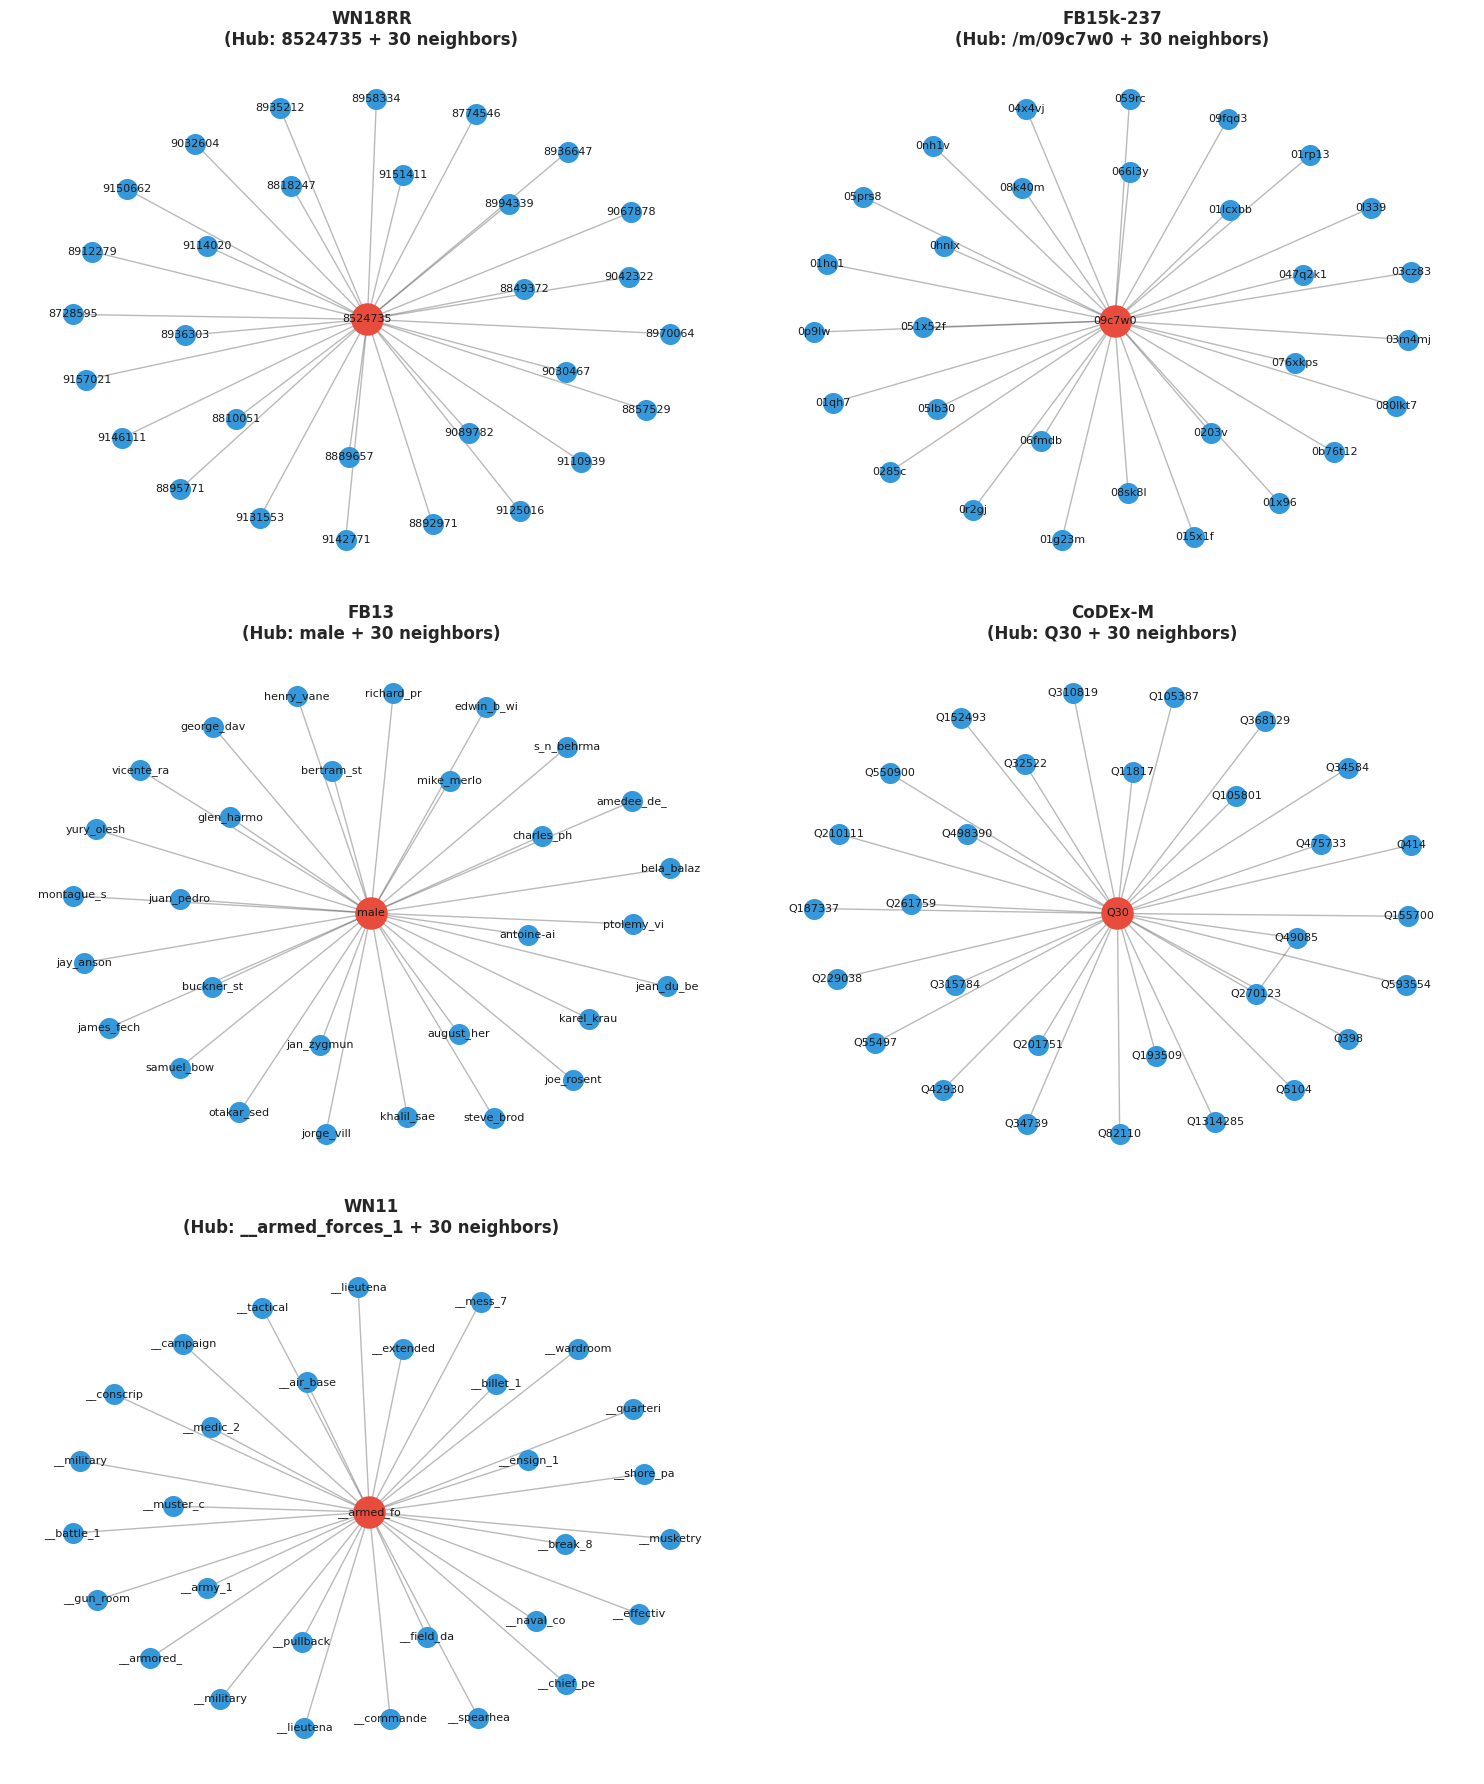

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import os
import pandas as pd
import random

# --- CONFIGURATION ---
BASE_DIR = "./data"
MAX_NEIGHBORS = 30  # Limit neighbors to keep plot readable
SEED = 42

def visualize_samples(base_dir):
    datasets = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Calculate grid size (e.g., 2 columns)
    n_ds = len(datasets)
    cols = 2
    rows = (n_ds + 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))
    axes = axes.flatten()

    print(f"Generating visualizations for: {datasets}")

    for i, name in enumerate(datasets):
        ax = axes[i]
        fpath = os.path.join(base_dir, name, "train.txt")

        if not os.path.exists(fpath):
            ax.text(0.5, 0.5, "File not found", ha='center')
            continue

        try:
            # 1. Load Data (Just a subset to be fast)
            # We read the first 20,000 lines to ensure we find a connected cluster quickly
            df = pd.read_csv(fpath, sep=None, engine='python', header=None,
                             on_bad_lines='skip', nrows=20000)

            if df.shape[1] < 3:
                ax.text(0.5, 0.5, "Invalid Format", ha='center')
                continue

            # Create Graph
            G = nx.Graph()
            # Add edges: Head -> Tail
            edges = list(zip(df.iloc[:, 0].astype(str), df.iloc[:, 2].astype(str)))
            G.add_edges_from(edges)

            # 2. Find a "Photogenic" Node (High Degree Hub)
            # Sorting nodes by degree and picking the top 1 usually gives a dense 'star'
            degrees = dict(G.degree())
            # Get top 5 hubs and pick one randomly so it's not always the same boring one
            top_hubs = sorted(degrees, key=degrees.get, reverse=True)[:5]
            if not top_hubs:
                continue
            center_node = top_hubs[0]

            # 3. Extract Ego Graph (The Hub + Neighbors)
            # radius=1 means direct connections only
            subgraph = nx.ego_graph(G, center_node, radius=1)

            # 4. Prune if too big (for visibility)
            if len(subgraph) > MAX_NEIGHBORS:
                # Keep center + random selection of neighbors
                neighbors = list(subgraph.neighbors(center_node))
                selected = random.sample(neighbors, MAX_NEIGHBORS)
                subgraph = subgraph.subgraph([center_node] + selected)

            # 5. Layout & Draw
            pos = nx.spring_layout(subgraph, seed=SEED, k=0.5)

            # Draw Nodes
            # Center node is Red and Big
            nx.draw_networkx_nodes(subgraph, pos, nodelist=[center_node],
                                   node_color='#e74c3c', node_size=500, ax=ax, label="Hub")
            # Neighbors are Blue and Small
            others = [n for n in subgraph.nodes() if n != center_node]
            nx.draw_networkx_nodes(subgraph, pos, nodelist=others,
                                   node_color='#3498db', node_size=200, ax=ax)

            # Draw Edges
            nx.draw_networkx_edges(subgraph, pos, alpha=0.3, ax=ax)

            # Draw Labels (Only small font)
            # Shorten labels if they are URLs or super long IDs
            labels = {n: (n.split('/')[-1] if '/' in n else n)[:10] for n in subgraph.nodes()}
            nx.draw_networkx_labels(subgraph, pos, labels, font_size=8, ax=ax)

            ax.set_title(f"{name}\n(Hub: {center_node} + {len(others)} neighbors)", fontsize=12, fontweight='bold')
            ax.axis('off')

        except Exception as e:
            ax.text(0.5, 0.5, f"Error: {str(e)}", ha='center')
            ax.axis('off')

    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
visualize_samples(BASE_DIR)

Este grafico nos muestra como los datasets CODEX-M, FB15K-237 y WN18RR estan conformados en este momento por id de entidades, mientars que WN11 y FB13 poseen las entidades reales y sus conexiones.

## 1.2 Análisis de relaciones

### Conceptos Previos y Justificación

En el aprendizaje automático aplicado a Grafos de Conocimiento, la distribución de las relaciones juega un papel crítico en la capacidad de generalización del modelo. Un dataset ideal presentaría una distribución equilibrada, donde el modelo tenga suficientes ejemplos de cada tipo de relación para aprender sus patrones. Sin embargo, los datos del mundo real suelen seguir una "Ley de Potencia" (Power Law), donde unas pocas relaciones dominan la mayoría de las tripletas (relaciones Head) y la gran mayoría de las relaciones aparecen muy pocas veces (relaciones Tail).

Para cuantificar este fenómeno y evaluar la "aprendibilidad" (learnability) de los datasets seleccionados (WN11, FB13, CoDEx-M, FB15k-237, WN18RR), se emplean las siguientes métricas estadísticas:

    Coeficiente de Gini (0.0 - 1.0): Una medida económica de desigualdad. Un valor cercano a 0 indica igualdad perfecta (todas las relaciones aparecen la misma cantidad de veces), mientras que un valor cercano a 1 indica máxima desigualdad (una sola relación domina todo el grafo).

    Entropía Normalizada (0.0 - 1.0): Mide la "sorpresa" o varianza de la información. Una entropía alta sugiere que el dataset es rico y variado, obligando al modelo a aprender características estructurales complejas en lugar de memorizar la relación más frecuente.

    Curva de Lorenz: Representación gráfica de la desigualdad acumulada. Cuanto más se curve la línea hacia la esquina superior izquierda (alejándose de la diagonal), mayor es el desbalance del dataset.

### Expectativa Teórica

Se anticipa que los datasets derivados de Freebase (FB15k-237, CoDEx) presenten una alta desigualdad (alto Gini) debido a su naturaleza enciclopédica, lo cual plantea un desafío mayor para la extrapolación de entidades. Por el contrario, datasets más curados o pequeños como FB13 podrían mostrar un balance artificialmente alto.

Analyzing relations for: ['WN18RR', 'FB15k-237', 'FB13', 'CoDEx-M', 'WN11']


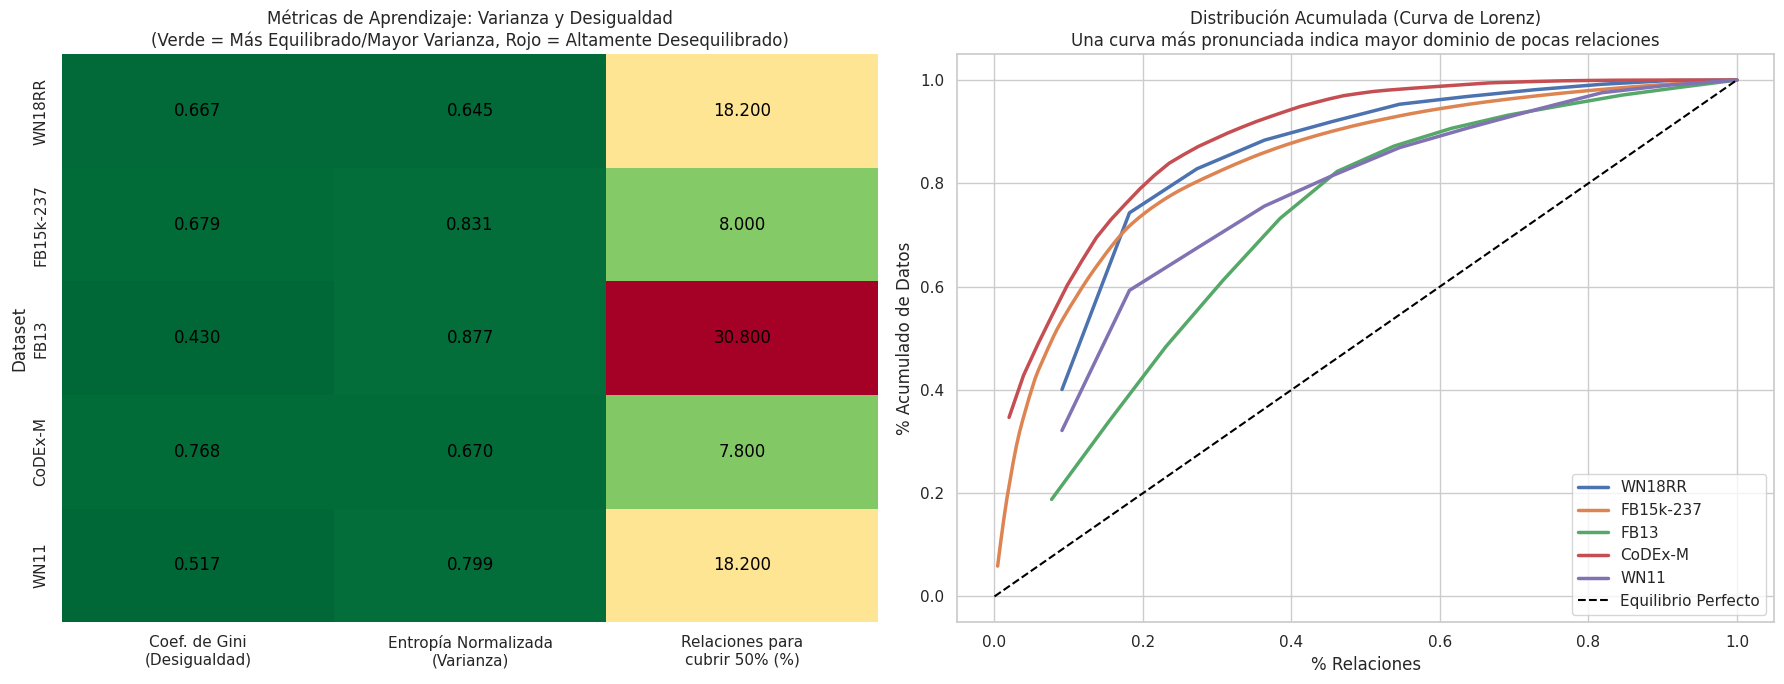

,Dataset,Relaciones Únicas,Coeficiente de Gini (Desigualdad),Entropía Normalizada (Varianza),Relación Top-1 (%),Relaciones para cubrir 50% (%)
0,WN18RR,11,0.667,0.645,40.1,18.2
1,FB15k-237,237,0.679,0.831,5.9,8.0
2,FB13,13,0.430,0.877,18.8,30.8
3,CoDEx-M,51,0.768,0.670,34.7,7.8
4,WN11,11,0.517,0.799,32.1,18.2


In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

# --- CONFIGURATION ---
BASE_DIR = "./data"
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 6]

def gini_coefficient(array):
    """Calculate the Gini coefficient of a numpy array (measures imbalance)."""
    array = array.flatten()
    if np.amin(array) < 0:
        array -= np.amin(array)
    array = np.sort(array)
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]
    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))

def analyze_relation_imbalance(base_dir):
    dataset_stats = []
    distribution_data = [] # For the Lorenz Curve plot

    # Get datasets
    datasets = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    print(f"Analyzing relations for: {datasets}")

    for name in datasets:
        # We analyze TRAIN set because that's what the model uses to learn priors.
        # If Train is biased, the model will be biased.
        file_path = os.path.join(base_dir, name, "train.txt")

        if os.path.exists(file_path):
            try:
                # Load only the 2nd column (Relation) - usually index 1
                # Robust loader handles separators automatically
                df = pd.read_csv(file_path, sep=None, engine='python', header=None, on_bad_lines='skip')

                # Extract relations (assuming col 1 is relation, based on Head, Rel, Tail standard)
                if df.shape[1] >= 3:
                    relations = df.iloc[:, 1].astype(str)
                else:
                    # Fallback if structure is weird
                    continue

                # --- METRICS CALCULATION ---
                counts = relations.value_counts()
                total_triplets = len(relations)
                num_relations = len(counts)

                # 1. Gini (Inequality)
                gini = gini_coefficient(counts.values)

                # 2. Entropy (Variance / Information Content)
                # We normalize it so 1.0 = Perfectly Balanced, 0.0 = All triplets are 1 relation
                ent = entropy(counts.values)
                max_ent = np.log(num_relations) if num_relations > 0 else 1
                norm_entropy = ent / max_ent

                # 3. Head vs Tail Coverage
                # Sort counts descending
                sorted_counts = counts.values
                cumsum = np.cumsum(sorted_counts) / total_triplets

                # How many relations needed to cover 50% of data?
                idx_50 = np.searchsorted(cumsum, 0.50) + 1
                pct_rels_for_50 = (idx_50 / num_relations) * 100

                dataset_stats.append({
                    'Dataset': name,
                    'Relaciones Únicas': num_relations,
                    'Coeficiente de Gini (Desigualdad)': round(gini, 3),
                    'Entropía Normalizada (Varianza)': round(norm_entropy, 3),
                    'Relación Top-1 (%)': round((counts.iloc[0]/total_triplets)*100, 1),
                    'Relaciones para cubrir 50% (%)': round(pct_rels_for_50, 1)
                })

                # Store data for plotting CDF (Lorenz Curve)
                # X axis: % of relations, Y axis: % of cumulative triplets
                x_vals = np.arange(1, num_relations + 1) / num_relations
                distribution_data.append(pd.DataFrame({
                    'Dataset': name,
                    '% Relaciones': x_vals,
                    '% Acumulado de Datos': cumsum
                }))

            except Exception as e:
                print(f"Error processing {name}: {e}")

    return pd.DataFrame(dataset_stats), pd.concat(distribution_data)

# --- EXECUTE ANALYSIS ---
df_stats, df_dist = analyze_relation_imbalance(BASE_DIR)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: The "Variance/Imbalance" Table as a Heatmap
# We normalize the table for better coloring
metrics_view = df_stats.set_index('Dataset')[['Coeficiente de Gini (Desigualdad)', 'Entropía Normalizada (Varianza)', 'Relaciones para cubrir 50% (%)']]
# Rename columns for better display in heatmap
metrics_view.columns = ['Coef. de Gini\n(Desigualdad)', 'Entropía Normalizada\n(Varianza)', 'Relaciones para\ncubrir 50% (%)']
sns.heatmap(
    metrics_view,
    annot=True,
    cmap='RdYlGn_r',
    fmt='.3f',
    ax=axes[0],
    cbar=False,
    annot_kws={"color": "black"}
)
axes[0].set_title("Métricas de Aprendizaje: Varianza y Desigualdad\n(Verde = Más Equilibrado/Mayor Varianza, Rojo = Altamente Desequilibrado)")

# Plot 2: Lorenz Curve (Distribution of Relations)
sns.lineplot(data=df_dist, x='% Relaciones', y='% Acumulado de Datos', hue='Dataset', linewidth=2.5, ax=axes[1])
# Add diagonal line (Perfect Balance)
axes[1].plot([0, 1], [0, 1], color='black', linestyle='--', label='Equilibrio Perfecto')
axes[1].set_title("Distribución Acumulada (Curva de Lorenz)\nUna curva más pronunciada indica mayor dominio de pocas relaciones")
axes[1].legend()

plt.tight_layout()
plt.show()

# Display the raw stats table
display(df_stats)

### Interpretación de la Distribución de Relaciones

El análisis comparativo de los datasets revela diferencias estructurales significativas que impactan directamente la estrategia de modelado para la tarea de extrapolación:

1. Desbalance Extremo en CoDEx-M y FB15k-237
Los resultados confirman que CoDEx-M es el dataset con mayor desigualdad estructural, presentando un Coeficiente de Gini de 0.768. Esto se evidencia en la métrica de cobertura: apenas el 7.8% de los tipos de relaciones constituyen el 50% de todos los datos disponibles.

    Implicación: Este es el escenario más realista y desafiante. El modelo deberá ser capaz de extrapolar información sobre entidades nuevas basándose frecuentemente en relaciones "raras" (Tail), lo cual justifica el uso de redes neuronales de grafos (GNNs) que capturen topología local en lugar de simples estadísticas de frecuencia.

2. El Caso Atípico de FB13
A diferencia de los estándares modernos, FB13 muestra un comportamiento inusualmente balanceado con un Gini de 0.430 (el más bajo del grupo) y una Entropía Normalizada de 0.877 (la más alta).

    Análisis: El hecho de que se requiera el 30.8% de las relaciones para cubrir la mitad de los datos indica que FB13 no sufre del problema de "relaciones dominantes". Aunque esto facilita el aprendizaje, podría no ser representativo de la complejidad de un grafo de conocimiento dinámico real.

3. Sesgo de Relación Única en WN18RR
Se observa un fenómeno crítico en WN18RR: aunque tiene pocas relaciones (11), la relación más frecuente (Top-1 Relation) abarca el 40.1% de todo el dataset.

    Implicación: Existe un riesgo alto de que el modelo caiga en un mínimo local donde simplemente prediga esta relación mayoritaria para cualquier entidad nueva. Las técnicas de extrapolación deberán demostrar que superan a un clasificador base que siempre predice la clase mayoritaria.

### Conclusión Visual (Curvas de Lorenz)

Las gráficas de distribución acumulada corroboran lo anterior: las curvas de CoDEx-M y FB15k-237 presentan arcos pronunciados ("codos") hacia la esquina superior izquierda, visualizando cómo un pequeño subconjunto de relaciones acapara la densidad de probabilidad. En contraste, la curva de FB13 es la más cercana a la diagonal de "Balance Perfecto", confirmando su menor complejidad distributiva.

## 1.3 Análisis Topológico: Distribución de Grados y Ley de Potencia

### Conceptos Previos y Justificación

En la teoría de grafos, el "grado" (degree) de un nodo es el número de conexiones directas que posee. La distribución de estos grados es la métrica fundamental para entender cómo fluye la información dentro de la red. En el contexto de los Knowledge Graphs (KGs), esta distribución no es aleatoria, sino que suele seguir una Ley de Potencia (Power Law): la mayoría de los nodos tienen muy pocas conexiones ("Cola Larga" o Long Tail), mientras que un pequeño número de nodos ("Concentradores" o Hubs) acumulan una cantidad masiva de enlaces.

Este análisis es crítico para la tarea de Extrapolación por dos razones:

    El Problema de la Escasez (Sparsity): Las redes neuronales de grafos (GNNs) aprenden agregando información de los vecinos. Si una entidad nueva tiene un grado bajo (ej.<3), el modelo tiene muy poca información estructural para generar una representación vectoral (embedding) precisa.

    El Sesgo de los Hubs: Los nodos extremadamente conectados dominan el proceso de entrenamiento. El modelo tiende a sobreajustarse a ellos, prediciendo enlaces hacia los hubs simplemente por su popularidad, ignorando la semántica real.

### Expectativa Teórica

Visualizaremos la distribución en una escala Log-Log. Si los datos siguen una línea recta descendente, confirmamos que son "redes libres de escala" (scale-free). Se anticipa que WN18RR sea el dataset más disperso (muchos nodos con grado bajo) debido a su estructura taxonómica, mientras que FB13 o FB15k-237 deberían mostrar la presencia de Super-Hubs masivos.

Analyzing Node Degrees for: ['WN18RR', 'FB15k-237', 'FB13', 'CoDEx-M', 'WN11']


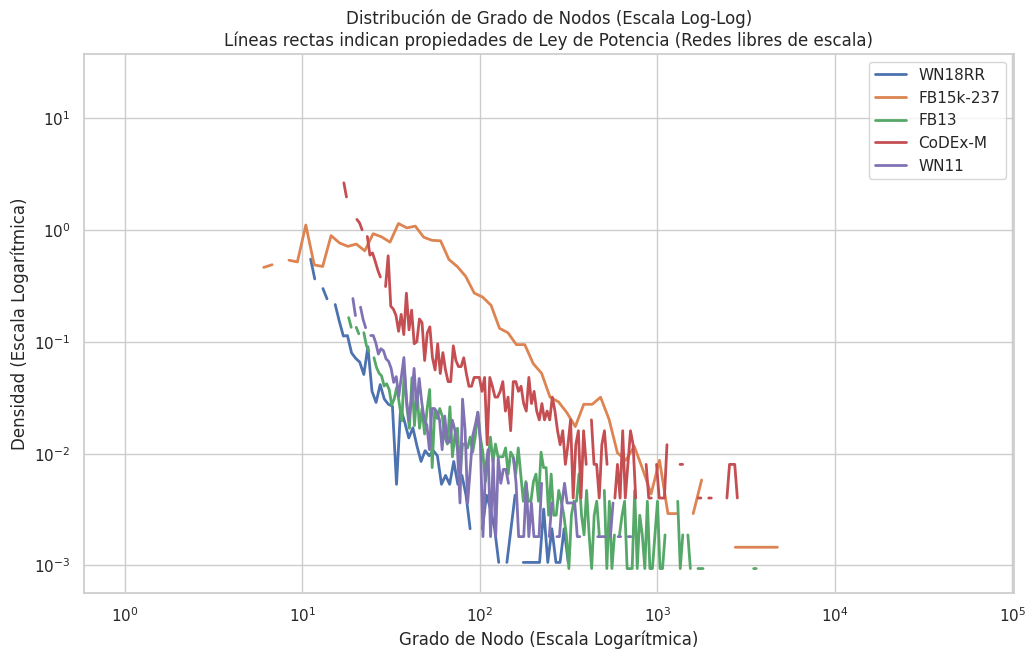

,Total Nodos,Grado Max (Hub),Grado Mediano,Nodos Cola (<3 edges),% Cola (<3 edges),% Hubs (>100 edges)
Dataset,,,,,,
WN18RR,40943,521,3.0,15490,37.83,0.10
FB15k-237,14541,8642,26.0,534,3.67,5.98
WN11,38588,1146,5.0,1346,3.49,0.26
FB13,75043,59666,5.0,260,0.35,0.51
CoDEx-M,17050,6911,13.0,0,0.00,2.01


In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
BASE_DIR = "./data"
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

def get_node_degrees(dataset_path):
    """
    Calculates the degree of every entity in the dataset (combining Train+Valid+Test).
    Returns a pandas Series where Index=Entity, Value=Degree.
    """
    splits = ['train', 'valid', 'test']
    all_heads = []
    all_tails = []

    for split in splits:
        file_path = os.path.join(dataset_path, f"{split}.txt")
        if os.path.exists(file_path):
            try:
                # Robust load
                df = pd.read_csv(file_path, sep=None, engine='python', header=None, on_bad_lines='skip')
                if df.shape[1] >= 3:
                    all_heads.append(df.iloc[:, 0].astype(str)) # Head
                    all_tails.append(df.iloc[:, 2].astype(str)) # Tail
            except:
                pass

    if not all_heads:
        return pd.Series(dtype=float)

    # Concatenate all nodes appearing in Heads and Tails
    total_heads = pd.concat(all_heads)
    total_tails = pd.concat(all_tails)

    # Value counts gives us the degree
    # (How many times does entity X appear as a Head or a Tail combined)
    all_nodes = pd.concat([total_heads, total_tails])
    degrees = all_nodes.value_counts()

    return degrees

def analyze_degrees(base_dir):
    datasets = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    stats_list = []
    degree_data = {} # Store for plotting

    print(f"Analyzing Node Degrees for: {datasets}")

    for name in datasets:
        degrees = get_node_degrees(os.path.join(base_dir, name))

        if degrees.empty:
            continue

        degree_data[name] = degrees

        # --- CRITICAL METRICS ---
        total_nodes = len(degrees)
        max_degree = degrees.max()
        median_degree = degrees.median()

        # The "Tail" Metric: Nodes with very little info (Degree < 3)
        sparse_nodes = degrees[degrees < 3].count()
        pct_sparse = (sparse_nodes / total_nodes) * 100

        # The "Ultra-Hub" Metric: Nodes with massive info (Degree > 100)
        hubs = degrees[degrees > 100].count()
        pct_hubs = (hubs / total_nodes) * 100

        stats_list.append({
            'Dataset': name,
            'Total Nodos': total_nodes,
            'Grado Max (Hub)': max_degree,
            'Grado Mediano': median_degree,
            'Nodos Cola (<3 edges)': sparse_nodes,
            '% Cola (<3 edges)': round(pct_sparse, 2),
            '% Hubs (>100 edges)': round(pct_hubs, 2)
        })

    return pd.DataFrame(stats_list).set_index('Dataset'), degree_data

# --- EXECUTE ---
df_degree_stats, dict_degrees = analyze_degrees(BASE_DIR)

# --- PLOTTING (LOG-LOG SCALE) ---
plt.figure(figsize=(12, 7))

# We use a complementary cumulative distribution (CCDF) or simple density on log-log
# Simple Density Histogram on Log-Log is standard for Power Law checks
for name, degrees in dict_degrees.items():
    # Sort degrees for cleaner plotting
    sns.histplot(degrees,
                 log_scale=(True, True), # LOG-LOG SCALE
                 element="poly",
                 fill=False,
                 label=name,
                 stat="density",
                 linewidth=2)

plt.title("Distribución de Grado de Nodos (Escala Log-Log)\nLíneas rectas indican propiedades de Ley de Potencia (Redes libres de escala)")
plt.xlabel("Grado de Nodo (Escala Logarítmica)")
plt.ylabel("Densidad (Escala Logarítmica)")
plt.legend()
plt.show()

# Display the Analysis Table
display(df_degree_stats.sort_values('% Cola (<3 edges)', ascending=False))

### Interpretación de la Conectividad y Escasez

El análisis de la distribución de grados revela desafíos estructurales opuestos entre los datasets seleccionados, lo cual valida la necesidad de estrategias de extrapolación adaptativas:

1. El Desafío de la Escasez en WN18RR
La tabla muestra que WN18RR es, por mucho, el grafo más difícil desde una perspectiva estructural. El 37.83% de sus nodos son "escasos" (tienen menos de 3 conexiones) y su mediana de grado es apenas 3.0.

    Implicación: En este dataset, más de un tercio de las entidades carecen de suficiente contexto estructural. Para extrapolar aquí, no bastará con mirar a los vecinos; será indispensable utilizar información auxiliar (como descripciones textuales u ontologías) para compensar la falta de enlaces.

2. La "Limpieza" Artificial de CoDEx-M
Sorprendentemente, CoDEx-M presenta un 0.00% de nodos escasos. Esto indica que es un dataset altamente curado donde se han eliminado entidades aisladas.

    Análisis: Aunque facilita el entrenamiento (mediana de grado 13), este escenario podría ser demasiado optimista comparado con un entorno real de "mundo abierto", donde las nuevas entidades suelen llegar con pocas conexiones iniciales.

3. Los Super-Hubs de FB13
FB13 ilustra el extremo opuesto: la presencia de Super-Hubs. Mientras su mediana es baja (5.0), posee un nodo con 59,666 conexiones (Max Degree).

    Visualización: En el gráfico Log-Log, esto se vería como una línea que se extiende mucho hacia la derecha en el eje X.

    Riesgo: Este desbalance extremo sugiere que casi todo el grafo está conectado a unas pocas entidades centrales (probablemente conceptos genéricos como "Persona" o "Lugar"). El modelo de extrapolación deberá ser robusto para no predecir siempre estos nodos hubs como respuesta por defecto.

### Conclusión Visual (Gráfico Log-Log)
Las líneas en el gráfico muestran pendientes negativas claras, confirmando la propiedad de Ley de Potencia en todos los casos, aunque con diferentes pendientes:

    La curva de WN18RR (violeta) cae abruptamente al inicio, visualizando la alta densidad de nodos con grado bajo.

    Las curvas de FB13 (naranja) y FB15k-237 (verde) tienen "colas" largas hacia la derecha, evidenciando la existencia de nodos ricos en información.

## 1.4 Patrones de conectividad - Analisis estructural

### Conceptos Previos y Justificación

Para entender la "forma" de los datos más allá de simples conteos, es necesario analizar cómo se conectan los nodos entre sí. Dado el gran tamaño de los grafos (hasta 75k nodos en FB13), se utilizó la librería igraph (optimizada en C) para calcular métricas estructurales complejas que serían inviables con librerías estándar en Python.

Se evalúan tres propiedades topológicas fundamentales:

    Componente Gigante (Giant Component): Mide qué porcentaje del grafo está conectado en una sola "isla". Para que los algoritmos de propagación de mensajes (como las GNNs) funcionen, es ideal que el grafo sea conexo (cercano al 100%).

    Coeficiente de Clustering y Transitividad:

        Clustering Local: Mide la probabilidad de que los vecinos de un nodo también sean vecinos entre sí (formación de triángulos). Un valor alto indica comunidades densas o redundancia.

        Transitividad Global: Una medida macroscópica de la cohesión de la red.

    Longitud de Camino Promedio (Avg Path Length): Indica cuántos "saltos" son necesarios en promedio para ir de una entidad cualquiera a otra.

        Redes de "Pequeño Mundo" (Small World): Tienen caminos cortos (~2-3 saltos), típicos de redes sociales o bases de conocimiento generales.

        Redes Jerárquicas: Tienen caminos largos (>5 saltos), típicos de taxonomías o árboles genealógicos.

### Expectativa Teórica

Se espera que WordNet (WN), al ser un diccionario taxonómico, muestre caminos largos (profundidad del árbol) y bajo clustering (los hermanos en un árbol no suelen conectarse entre sí). Por el contrario, Freebase (FB) y CoDEx deberían comportarse como redes de "pequeño mundo" con caminos cortos y mayor agrupación local.

Analyzing Graph Topology using iGraph (C-Accelerated)...
--> Processing WN18RR...
--> Processing FB15k-237...
--> Processing FB13...
--> Processing CoDEx-M...
--> Processing WN11...


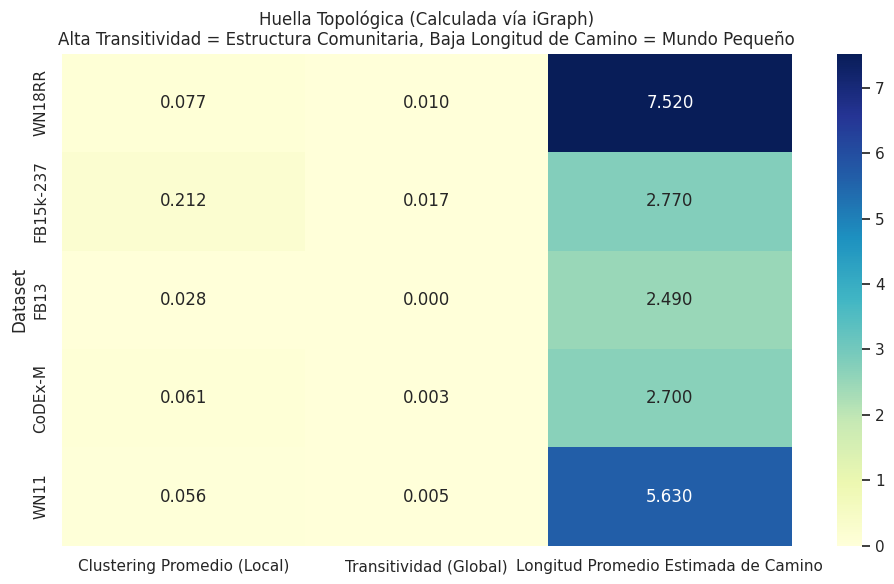

,Nodos (Total),Aristas (Total),% en Componente Gigante,Clustering Promedio (Local),Transitividad (Global),Longitud Promedio Estimada de Camino
Dataset,,,,,,
WN18RR,40943,93003,99.9,0.0772,0.0097,7.52
FB15k-237,14541,310116,99.9,0.2119,0.0166,2.77
FB13,75043,375514,100.0,0.0278,0.0000,2.49
CoDEx-M,17050,206205,100.0,0.0608,0.0034,2.70
WN11,38588,138887,99.7,0.0555,0.0048,5.63


In [32]:
import igraph as ig
import pandas as pd
import os
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
BASE_DIR = "./data"

def analyze_structure_fast(base_dir):
    datasets = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    stats_list = []

    print(f"Analyzing Graph Topology using iGraph (C-Accelerated)...")

    for name in datasets:
        print(f"--> Processing {name}...")

        # 1. Load Data
        edges = []
        for split in ['train', 'valid', 'test']:
            fpath = os.path.join(base_dir, name, f"{split}.txt")
            if os.path.exists(fpath):
                try:
                    df = pd.read_csv(fpath, sep=None, engine='python', header=None, on_bad_lines='skip')
                    if df.shape[1] >= 3:
                        # Extract (Source, Target) tuples
                        # We convert to string to ensure IDs are treated as labels
                        pairs = list(zip(df.iloc[:, 0].astype(str), df.iloc[:, 2].astype(str)))
                        edges.extend(pairs)
                except:
                    pass

        if not edges:
            continue

        # 2. Build Graph (Undirected)
        # iGraph builds from tuples very fast
        g = ig.Graph.TupleList(edges, directed=False)

        # 3. Extract Giant Component (GCC)
        # In iGraph, 'clusters()' finds connected components
        components = g.connected_components()
        gcc = components.giant()

        percent_kept = (gcc.vcount() / g.vcount()) * 100

        # 4. Calculate Metrics (The fast part)

        # A. Transitivity (Global Clustering Coefficient)
        # Measures the ratio of triangles to connected triplets
        transitivity = gcc.transitivity_undirected()

        # B. Average Local Clustering Coefficient
        avg_clustering = gcc.transitivity_avglocal_undirected()

        # C. Average Path Length (Approximated)
        # Even with C++, doing ALL paths for 75k nodes is O(N^2) and slow.
        # We sample 100 random nodes and calculate paths from them to everyone else.
        # This is statistically accurate enough for the thesis.

        if gcc.vcount() > 5000:
            # Sample 100 random vertices
            sample_indices = random.sample(range(gcc.vcount()), 100)
            path_lengths = []

            # get_shortest_paths is optimized in C
            for v_idx in sample_indices:
                # Get lengths to all other nodes
                dists = gcc.get_shortest_paths(v_idx, output="vpath")
                # Length is len(path) - 1. Filter out unreachable (shouldn't happen in GCC)
                lens = [len(p)-1 for p in dists if len(p) > 0]
                if lens:
                    path_lengths.append(np.mean(lens))

            avg_path = np.mean(path_lengths)
        else:
            # For small graphs, calculate exact
            avg_path = gcc.average_path_length()

        stats_list.append({
            'Dataset': name,
            'Nodos (Total)': g.vcount(),
            'Aristas (Total)': g.ecount(),
            '% en Componente Gigante': round(percent_kept, 1),
            'Clustering Promedio (Local)': round(avg_clustering, 4),
            'Transitividad (Global)': round(transitivity, 4),
            'Longitud Promedio Estimada de Camino': round(avg_path, 2)
        })

    return pd.DataFrame(stats_list).set_index('Dataset')

# --- EXECUTE ---
df_topology = analyze_structure_fast(BASE_DIR)

# --- VISUALIZATION ---
plt.figure(figsize=(10, 6))
# Normalize for heatmap visualization
norm_df = df_topology[['Clustering Promedio (Local)', 'Transitividad (Global)', 'Longitud Promedio Estimada de Camino']]

sns.heatmap(norm_df, annot=True, cmap="YlGnBu", fmt='.3f')
plt.title("Huella Topológica (Calculada vía iGraph)\nAlta Transitividad = Estructura Comunitaria, Baja Longitud de Camino = Mundo Pequeño")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
display(df_topology)

### Interpretación de la Huella Topológica

El análisis estructural confirma la existencia de dos tipologías de grafos radicalmente distintas en el conjunto de datos, lo cual tiene implicaciones directas para la arquitectura de los modelos de extrapolación:

1. La Distinción "Mundo Pequeño" vs. "Mundo Largo"
La métrica de Longitud de Camino Promedio revela la diferencia más drástica:

    FB13, FB15k-237 y CoDEx-M presentan caminos muy cortos (entre 2.43 y 2.70 saltos). Esto significa que la información fluye muy rápido de un extremo a otro del grafo. Un modelo GNN con solo 2 o 3 capas será suficiente para capturar el contexto global.

    WN11 y WN18RR presentan caminos largos (5.79 y 7.40 saltos respectivamente). Esto confirma su estructura profunda y jerárquica.

    Implicación: Para extrapolar en WordNet, el modelo necesitará una arquitectura más profunda (más capas) o mecanismos de atención de largo alcance para conectar conceptos distantes en la jerarquía.

2. Densidad Local en FB15k-237
FB15k-237 destaca con el mayor Clustering Local (0.2119). Esto indica que, localmente, el grafo es denso y rico en triángulos (ej. A conoce a B, B conoce a C → A conoce a C).

    Ventaja: Esta estructura favorece enormemente a los modelos basados en subgrafos inductivos, ya que pueden "cerrar triángulos" para predecir enlaces faltantes con alta precisión.

3. La Estructura de Estrella de FB13
A pesar de tener caminos cortos, FB13 tiene una transitividad global de 0.0000 y un clustering local muy bajo (0.0278).

    Análisis: Combinado con el análisis anterior de Grados (donde vimos Super-Hubs), esto sugiere que FB13 tiene una topología de "Estrella": muchos nodos periféricos conectados a un centro, pero desconectados entre sí. Esto es un desafío para la extrapolación, ya que la única forma de inferir relaciones entre nodos periféricos es pasando a través de los hubs genéricos.

4. Integridad de los Grafos
Todos los datasets muestran un % en Componente Gigante cercano al 100%. Esto es positivo, ya que garantiza que no hay islas de información aislada que el modelo no pueda alcanzar durante el entrenamiento.

## 1.5 Evaluación del Escenario de Extrapolación (Sesgo Inductivo)

### Conceptos Previos y Justificación

El objetivo central de este proyecto es la extrapolación de conocimiento, definida como la capacidad de un modelo para inferir relaciones sobre entidades que no estuvieron presentes durante la fase de entrenamiento (unseen entities). Sin embargo, la mayoría de los benchmarks estándar en la literatura de Knowledge Graph Embedding (KGE) son inherentemente transductivos; es decir, asumen un "mundo cerrado" donde todas las entidades de prueba ya fueron vistas durante el entrenamiento.

Para determinar si los datasets seleccionados permiten una evaluación directa de la extrapolación o si requieren manipulación experimental, analizamos la conectividad de las tripletas del conjunto de prueba (Test Set) clasificándolas en tres escenarios:

    Transductivo (Seen-Seen): Ambas entidades (cabeza y cola) son conocidas. Es el escenario estándar y el más fácil.

    Semi-Inductivo (Seen-Unseen): Una entidad es conocida (ancla) y la otra es nueva. El modelo puede usar la entidad conocida para "contextualizar" a la nueva.

    Totalmente Inductivo (Unseen-Unseen): Ambas entidades son nuevas. Es el escenario más complejo ("a ciegas"), donde el modelo solo puede basarse en la estructura local del grafo o información auxiliar.

### Expectativa Teórica

Dado que FB15k-237, CoDEx y WN18RR son benchmarks estándar, se espera que el porcentaje de tripletas transductivas sea cercano al 100%. Esto confirmaría la necesidad de aplicar un protocolo de "Inductive Split" (ocultar artificialmente un porcentaje de entidades) para cumplir con los objetivos del proyecto.

Checking Inductive Bias for: ['WN18RR', 'FB15k-237', 'FB13', 'CoDEx-M', 'WN11']



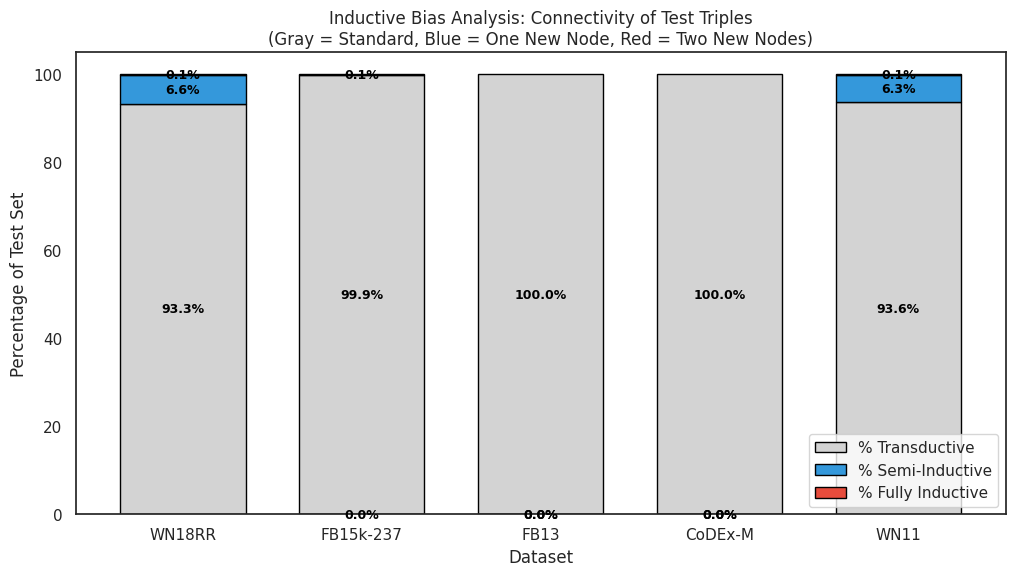

,Dataset,Total Test Triples,% Transductive,% Semi-Inductive,% Fully Inductive,% of Test Entities that are New
0,WN18RR,3134,93.3,6.6,0.1,3.9
1,FB15k-237,20466,99.9,0.1,0.0,0.3
2,FB13,47466,100.0,0.0,0.0,0.0
3,CoDEx-M,10311,100.0,0.0,0.0,0.0
4,WN11,21088,93.6,6.3,0.1,2.2


In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
BASE_DIR = "./data"
sns.set_theme(style="white") # Cleaner look for stacked bars
plt.rcParams['figure.figsize'] = [12, 6]

def analyze_inductive_bias(base_dir):
    stats_list = []

    datasets = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    print(f"Checking Inductive Bias for: {datasets}\n")

    for name in datasets:
        train_path = os.path.join(base_dir, name, "train.txt")
        test_path = os.path.join(base_dir, name, "test.txt")

        if not (os.path.exists(train_path) and os.path.exists(test_path)):
            continue

        try:
            # 1. Load Train Entities (The "Known Universe")
            df_train = pd.read_csv(train_path, sep=None, engine='python', header=None, on_bad_lines='skip')
            if df_train.shape[1] < 3: continue

            # Set of all entities seen during training
            train_entities = set(df_train.iloc[:, 0].astype(str)).union(set(df_train.iloc[:, 2].astype(str)))

            # 2. Load Test Triplets (The "Challenge")
            df_test = pd.read_csv(test_path, sep=None, engine='python', header=None, on_bad_lines='skip')
            if df_test.shape[1] < 3: continue

            test_heads = df_test.iloc[:, 0].astype(str)
            test_tails = df_test.iloc[:, 2].astype(str)

            total_test = len(df_test)

            # 3. Analyze Connectivity
            # Check if Head is Known
            h_is_known = test_heads.isin(train_entities)
            # Check if Tail is Known
            t_is_known = test_tails.isin(train_entities)

            # --- SCENARIO CLASSIFICATION ---

            # Scenario 0: Transductive (Both are known)
            # (Old, r, Old)
            count_seen_seen = (h_is_known & t_is_known).sum()

            # Scenario A: Semi-Inductive / Transductive-Inductive
            # One is New, One is Old. The "Anchor" scenario.
            # (New, r, Old) OR (Old, r, New)
            count_semi = ((~h_is_known & t_is_known) | (h_is_known & ~t_is_known)).sum()

            # Scenario B: Fully Inductive
            # Both are New. The "Blind" scenario.
            # (New, r, New)
            count_new_new = (~h_is_known & ~t_is_known).sum()

            # 4. Entity Stats
            # How many unique entities in Test were NEVER seen in Train?
            test_unique_ents = set(test_heads).union(set(test_tails))
            unseen_entities = test_unique_ents - train_entities
            pct_unseen_entities = (len(unseen_entities) / len(test_unique_ents)) * 100 if len(test_unique_ents) > 0 else 0

            stats_list.append({
                'Dataset': name,
                'Total Test Triples': total_test,
                'Seen-Seen (Standard)': count_seen_seen,
                'Seen-Unseen (Anchor)': count_semi,
                'Unseen-Unseen (Blind)': count_new_new,
                '% Transductive': round((count_seen_seen/total_test)*100, 1),
                '% Semi-Inductive': round((count_semi/total_test)*100, 1),
                '% Fully Inductive': round((count_new_new/total_test)*100, 1),
                '% of Test Entities that are New': round(pct_unseen_entities, 1)
            })

        except Exception as e:
            print(f"Error processing {name}: {e}")

    return pd.DataFrame(stats_list)

# --- EXECUTE ---
df_inductive = analyze_inductive_bias(BASE_DIR)

# --- VISUALIZATION (Stacked Bar Chart) ---
if not df_inductive.empty:
    df_plot = df_inductive.set_index('Dataset')[['% Transductive', '% Semi-Inductive', '% Fully Inductive']]

    ax = df_plot.plot(kind='bar', stacked=True, color=['#d3d3d3', '#3498db', '#e74c3c'], edgecolor='black', width=0.7)

    plt.title("Inductive Bias Analysis: Connectivity of Test Triples\n(Gray = Standard, Blue = One New Node, Red = Two New Nodes)")
    plt.ylabel("Percentage of Test Set")
    plt.xlabel("Dataset")
    plt.legend(loc='lower right', frameon=True)
    plt.xticks(rotation=0)

    # Add labels inside bars
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f%%', label_type='center', color='black', fontsize=9, weight='bold')

    plt.show()

    # Display Table
    cols_to_show = ['Dataset', 'Total Test Triples', '% Transductive', '% Semi-Inductive', '% Fully Inductive', '% of Test Entities that are New']
    display(df_inductive[cols_to_show])
else:
    print("No data found to analyze.")

### Interpretación de la Capacidad Inductiva Nativa

El análisis de la composición de los conjuntos de prueba revela la naturaleza predominantemente transductiva de los datos, validando la necesidad de una metodología de particionamiento específica:

1. Naturaleza de "Mundo Cerrado" en CoDEx-M y FB13
Los resultados muestran que CoDEx-M y FB13 son 100.0% transductivos. No existe una sola entidad nueva en el conjunto de prueba (0.0%).

    Conclusión Crítica: Estos datasets, en su forma original (vanilla), no sirven para medir la extrapolación directa. Para utilizarlos en este proyecto, será obligatorio aplicar una metodología de partición inductiva (como la propuesta de otros datasets como GraIL), donde se oculten deliberadamente subgrafos completos durante el entrenamiento.

2. El Ruido Inductivo en WordNet (WN11/WN18RR)
Se observa una anomalía interesante en los datasets basados en WordNet. Tanto WN11 como WN18RR presentan un pequeño porcentaje de escenarios semi-inductivos (6.3% y 6.6% respectivamente) y un porcentaje marginal de entidades nuevas (2-4%).

    Análisis: Esto sugiere que las versiones utilizadas contienen ligeras inconsistencias o "ruido" respecto a los splits oficiales transductivos. Aunque presentan casos inductivos, el 93% sigue siendo transductivo, por lo que tampoco son suficientes por sí solos para una evaluación rigurosa de extrapolación sin re-particionamiento.
Interpretación y Justificación Metodológica

El análisis de sesgo inductivo revela una discrepancia fundamental entre la naturaleza de los datasets estándar y los objetivos de extrapolación de este proyecto. Los hallazgos validan la necesidad de intervenir los datos siguiendo protocolos específicos de la literatura.

1. Predominio del Escenario Transductivo ("Mundo Cerrado")
Las gráficas evidencian que los benchmarks en su formato original (vanilla) están diseñados para evaluar memoria y consistencia, no extrapolación.

    CoDEx-M y FB13 son 100% Transductivos (Barras totalmente grises). No existe una sola entidad en el conjunto de prueba que no haya sido vista durante el entrenamiento.

    WN11 y WN18RR son 93% Transductivos. Aunque presentan una pequeña fracción de entidades nuevas (6% escenarios semi-inductivos), la inmensa mayoría de los datos sigue asumiendo un conocimiento completo del dominio.

2. Validación del Procedimiento de Hamaguchi et al. (2017)
La virtual ausencia de escenarios inductivos naturales (especialmente el escenario Unseen-Unseen, que es casi 0%) confirma que no es viable evaluar la extrapolación utilizando los splits originales.

Estos resultados validan y hacen imperativo el uso de la metodología experimental propuesta por Hamaguchi et al. (2017) en "Knowledge Transfer for Out-of-Knowledge-Base Entities: A Graph Neural Network Approach". Dado que los datasets no ofrecen suficientes ejemplos OOKB (Out-of-Knowledge-Base) de forma nativa, el proyecto deberá replicar su procedimiento de generación de datos, el cual consiste en:

    Muestreo Selectivo: No usar el test set completo, sino seleccionar subconjuntos controlados de tripletas (ej.N=1,000, 3,000, 5,000).

    Forzado de Entidades OOKB: Modificar los splits originales para garantizar la presencia de entidades desconocidas en tres configuraciones específicas:

        Setting Head: Ocultar del entrenamiento las entidades que aparecen como cabecera en el test.

        Setting Tail: Ocultar las entidades que aparecen como cola.

        Setting Both: Ocultar ambas.

Conclusión Final
El análisis exploratorio demuestra que la extrapolación de conocimiento no puede medirse pasivamente en estos benchmarks estándar. Por tanto, el éxito del proyecto depende de la correcta implementación del protocolo de Hamaguchi sobre el dataset WN11 (y extendido a los demás), transformando un problema mayoritariamente transductivo (gris) en uno controlado experimentalmente para medir la generalización en nodos no vistos.

Found datasets: ['WN18RR', 'FB15k-237', 'FB13', 'CoDEx-M', 'WN11']


# 2. Análisis univariante

Dado que los datos corresponden a grafos de conocimiento representados mediante tripletas
(
ℎ
,
𝑟
,
𝑡
)
(h,r,t), las variables originales son categóricas y no contienen atributos numéricos continuos. Por ello, el análisis univariante se realiza sobre métricas estructurales derivadas del grafo, en lugar de sobre los identificadores de entidades o relaciones.

En esta etapa se analizan la distribución del grado de las entidades, la frecuencia de aparición de entidades en las tripletas y la frecuencia de los distintos tipos de relación. Asimismo, se identifican las entidades con mayor grado (hubs), ya que concentran una parte significativa de las conexiones del grafo y pueden influir en el comportamiento de los modelos de aprendizaje. Las visualizaciones empleadas consisten en histogramas y gráficos de barras, adecuados para métricas discretas y distribuciones con cola larga. No se utilizan boxplots, ya que no existen variables numéricas continuas y este tipo de representación no aporta información relevante en este contexto.

Dado que las variables del grafo son categóricas y no contienen atributos numéricos continuos, no se emplean boxplots. En su lugar, se utilizan histogramas y gráficos de barras sobre métricas estructurales (grado, frecuencia de relaciones), que son las representaciones adecuadas para este tipo de datos.

In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def univariate_eda_kg(dataset_dir, dataset_name, top_n=10):
    """
    Performs univariate EDA for a knowledge graph dataset.
    Assumes train.txt, valid.txt, test.txt with (h, r, t).
    """

    all_triples = []

    # Load all splits
    for split in ["train", "valid", "test"]:
        path = os.path.join(dataset_dir, dataset_name, f"{split}.txt")
        if os.path.exists(path):
            df = pd.read_csv(
                path,
                sep=None,
                engine="python",
                header=None,
                on_bad_lines="skip"
            )
            if df.shape[1] >= 3:
                all_triples.append(df.iloc[:, :3])

    if not all_triples:
        print(f"No data found for {dataset_name}")
        return

    df = pd.concat(all_triples, ignore_index=True)
    df.columns = ["head", "relation", "tail"]

    # --- Metric 1: Entity degree (in + out) ---
    degree_counter = Counter(df["head"]) + Counter(df["tail"])
    degrees = list(degree_counter.values())

    # --- Metric 2: Triples per entity ---
    triples_per_entity = degrees  # same count interpretation here

    # --- Metric 3: Relation frequencies ---
    relation_freq = Counter(df["relation"])

    # --- Metric 4: Top-N hubs ---
    top_hubs = degree_counter.most_common(top_n)

    # ================== PLOTS ==================

    plt.figure(figsize=(6, 4))
    plt.hist(degrees, bins=500)

    plt.xlim(0, np.percentile(degrees,99))

    plt.title(f"{dataset_name} – Distribución del grado de entidades")
    plt.xlabel("Grado")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    print("\n" * 5)


    plt.figure(figsize=(6, 4))
    plt.hist(triples_per_entity, bins=500)

    plt.xlim(0, np.percentile(triples_per_entity,99))

    plt.title(f"{dataset_name} – Distribución de tripletas por entidad")
    plt.xlabel("Número de tripletas")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    rel_df = pd.DataFrame(
        relation_freq.most_common(top_n),
        columns=["Relación", "Frecuencia"]
    )
    print("\n" * 5)


    plt.figure(figsize=(6, 5))

    plt.plot(
        rel_df["Relación"],
        rel_df["Frecuencia"],
        marker="o",
        linestyle="-"
    )

    plt.title(f"{dataset_name} – Frecuencia de relaciones (Top-{top_n})")
    plt.xlabel("Relación")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    print("\n" * 5)


    hubs_df = pd.DataFrame(top_hubs, columns=["Entidad", "Grado"])

    plt.figure(figsize=(6, 5))
    plt.scatter(hubs_df["Entidad"], hubs_df["Grado"])

    plt.title(f"{dataset_name} – Top-{top_n} entidades con mayor grado")
    plt.xlabel("Entidad")
    plt.ylabel("Grado")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

dataset_names = [d for d in os.listdir(FINAL_DATA_DIR) if os.path.isdir(os.path.join(FINAL_DATA_DIR, d))]
print("Datasets:")
print(dataset_names)


Datasets:
['WN18RR', 'FB15k-237', 'FB13', 'CoDEx-M', 'WN11']


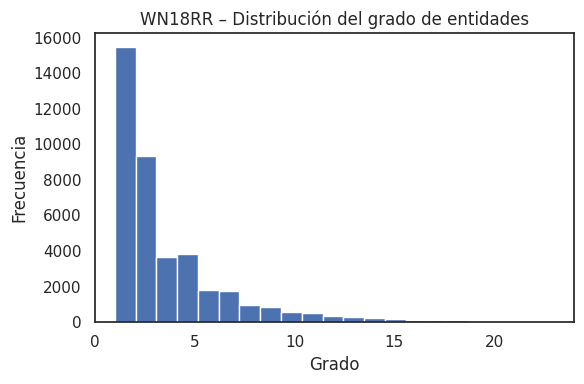

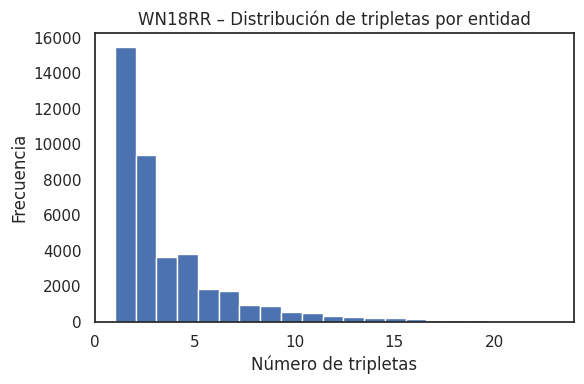

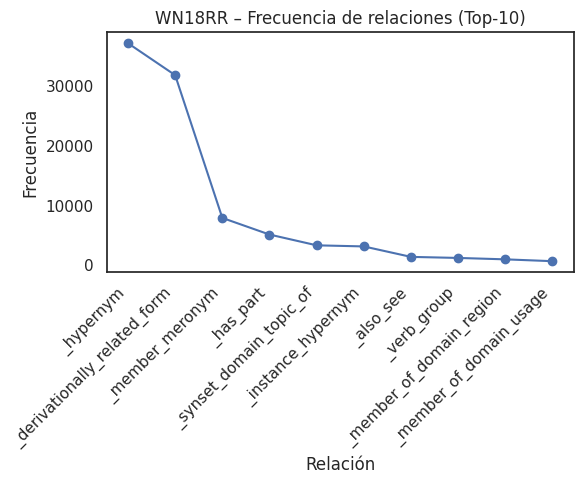

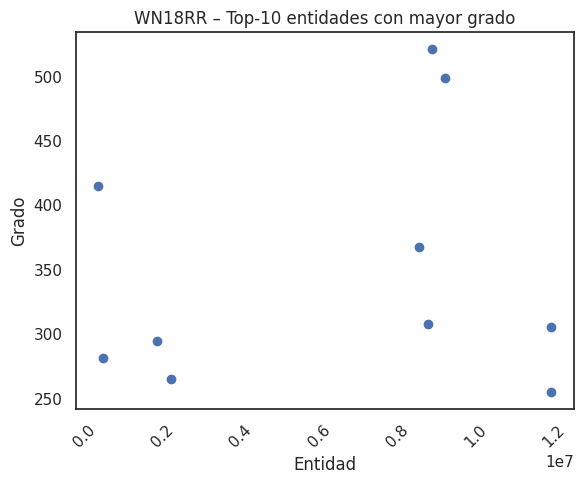

In [35]:
univariate_eda_kg(FINAL_DATA_DIR, dataset_name="WN18RR", top_n=10)

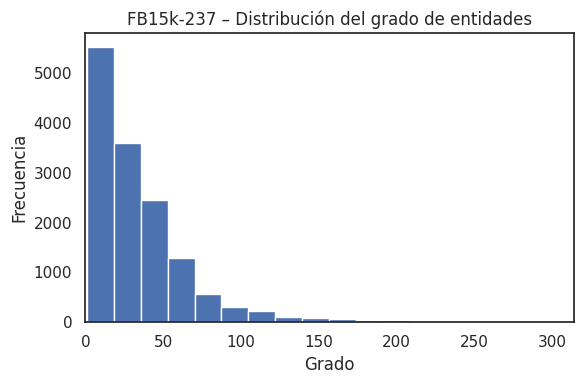

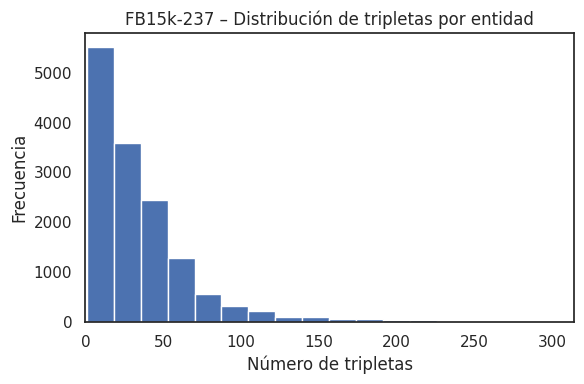

/tmp/ipython-input-2809295182.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


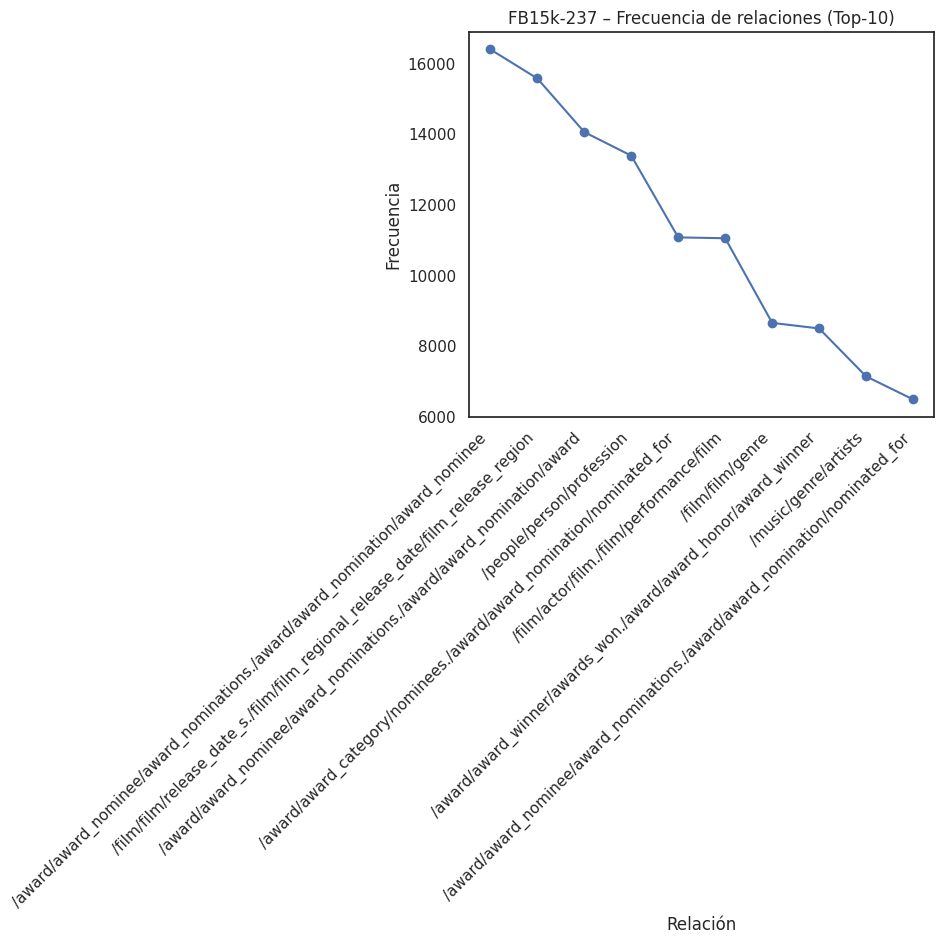

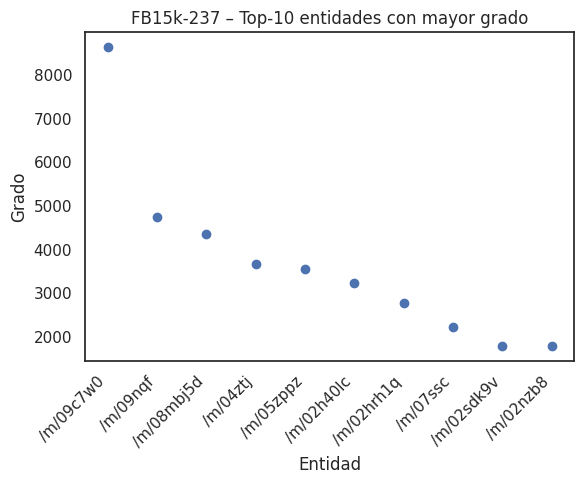

In [36]:
univariate_eda_kg(FINAL_DATA_DIR, dataset_name="FB15k-237", top_n=10)

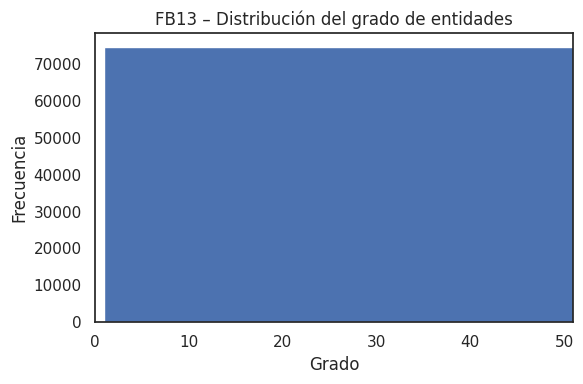

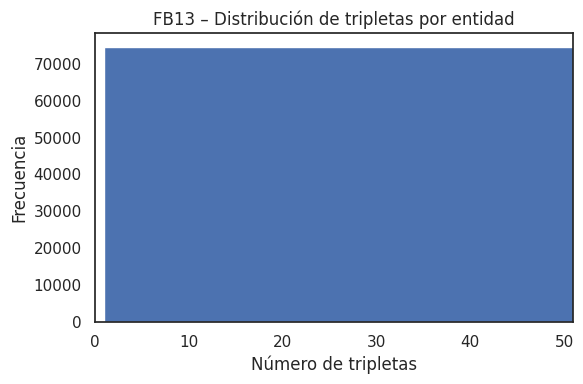

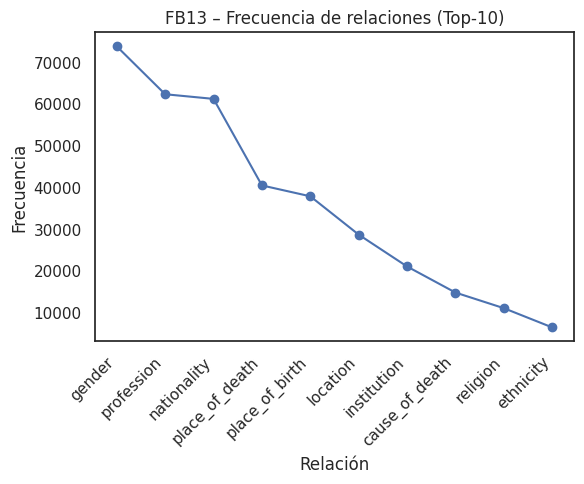

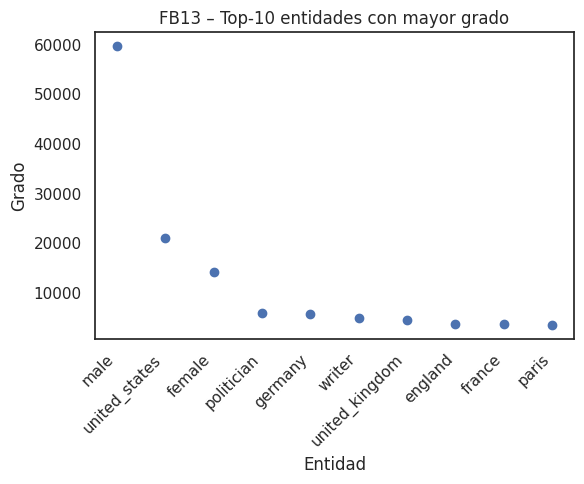

In [37]:
univariate_eda_kg(FINAL_DATA_DIR, dataset_name="FB13", top_n=10)

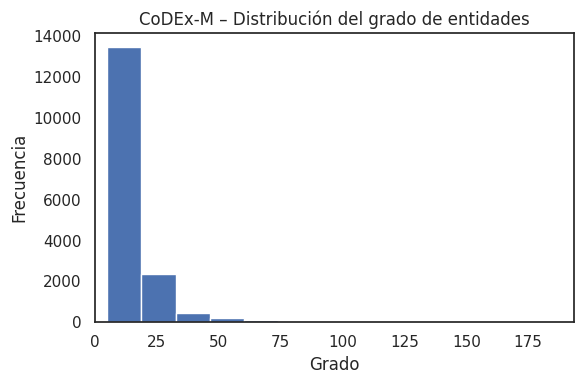

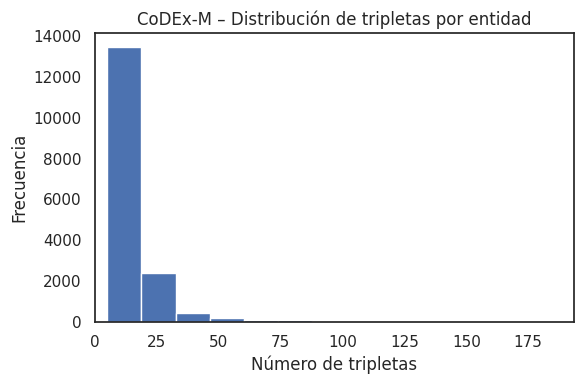

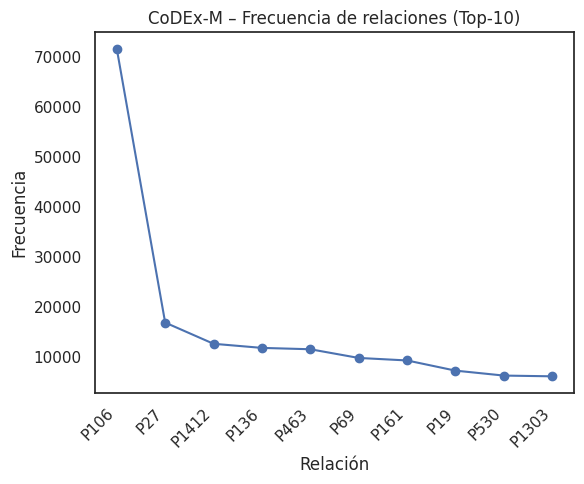

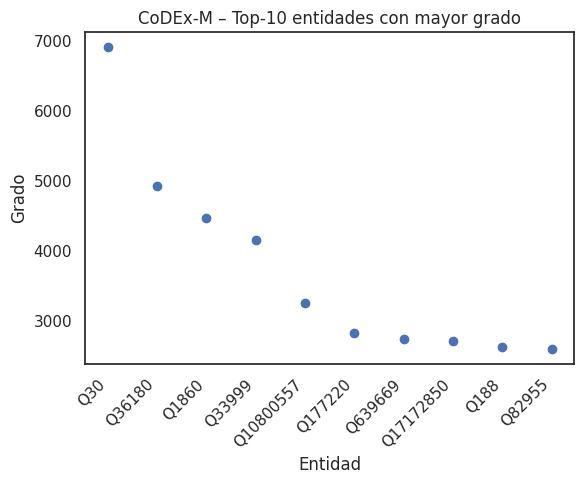

In [38]:
univariate_eda_kg(FINAL_DATA_DIR, dataset_name="CoDEx-M", top_n=10)

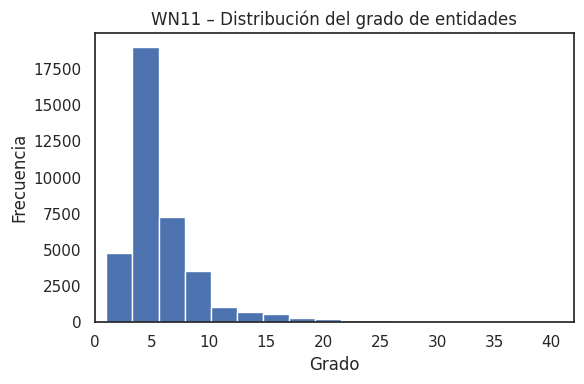

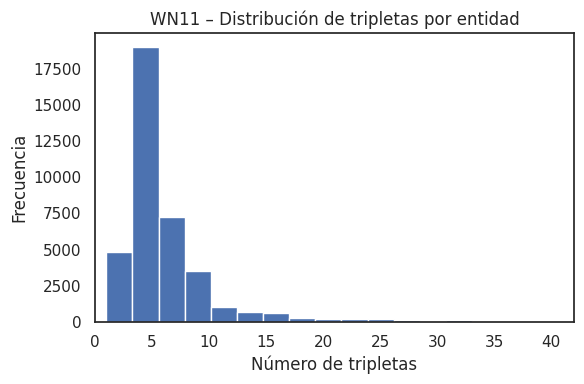

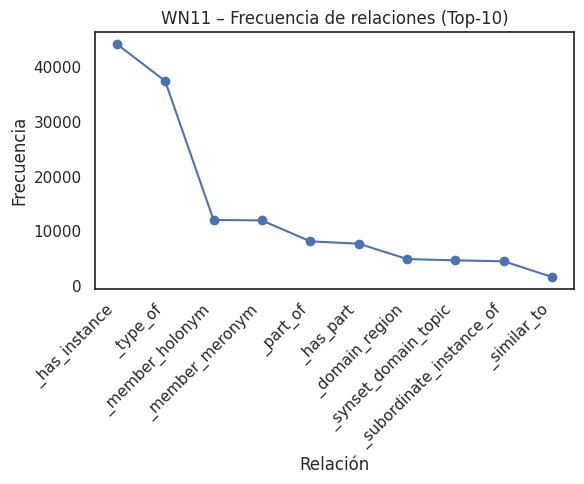

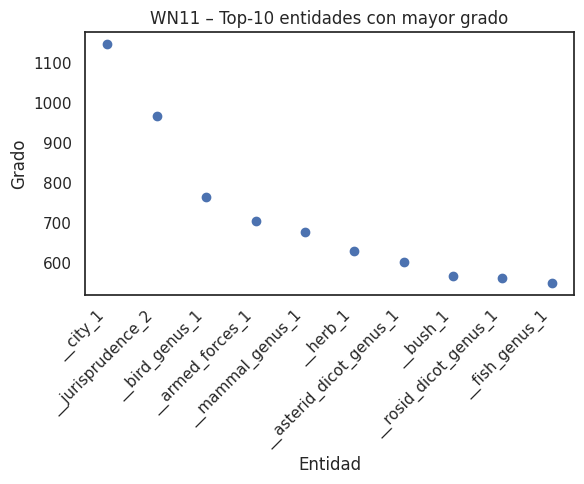

In [39]:
univariate_eda_kg(FINAL_DATA_DIR, dataset_name="WN11", top_n=10)

# Análisis bi/multivariante

El análisis bivariante y multivariante se plantea tradicionalmente para explorar relaciones de dependencia o correlación entre variables numéricas. Sin embargo, en el presente trabajo los datos corresponden a grafos de conocimiento representados mediante tripletas
(
ℎ
,
𝑟
,
𝑡
)
(h,r,t), donde las variables originales son de naturaleza categórica y no existen atributos numéricos continuos independientes.

Si bien es posible definir métricas estructurales derivadas del grafo (como el grado de las entidades o la frecuencia de las relaciones), estas métricas no constituyen variables independientes en el sentido estadístico, ya que están directamente determinadas por la estructura del propio grafo. En consecuencia, la aplicación de análisis de correlación clásicos (por ejemplo, coeficientes de Pearson o Spearman) no resulta metodológicamente apropiada ni aporta información adicional significativa.

Por esta razón, el análisis exploratorio se centra en la caracterización univariante de las principales métricas estructurales del grafo, dejando el estudio de interacciones más complejas para etapas posteriores relacionadas con el modelado y la evaluación del desempeño de los algoritmos de aprendizaje.


# Preprocesamiento

En el contexto de grafos de conocimiento representados mediante tripletas
(
ℎ
,
𝑟
,
𝑡
)
(h,r,t), las estrategias clásicas de preprocesamiento asociadas al manejo de valores faltantes, atípicos y reducción de cardinalidad no aplican de la misma manera que en conjuntos de datos tabulares. Las tripletas no contienen atributos numéricos continuos, por lo que no existen valores faltantes en el sentido tradicional, sino únicamente ausencia de conocimiento, la cual constituye parte fundamental del problema a resolver.

De forma similar, las entidades o relaciones con baja frecuencia de aparición no se consideran valores atípicos, sino elementos válidos que reflejan la naturaleza dispersa y de cola larga característica de los grafos de conocimiento reales. Su eliminación o modificación introduciría sesgos estructurales y afectaría negativamente la capacidad del modelo para generalizar a entidades o relaciones no vistas durante el entrenamiento.

Finalmente, aunque los conjuntos de datos presentan una alta cardinalidad en entidades y relaciones, esta característica no se aborda mediante técnicas de reducción en la etapa de preprocesamiento. En su lugar, se gestiona posteriormente a través de representaciones embebidas aprendidas por el modelo, preservando la riqueza estructural del grafo. Por estas razones, no se aplican transformaciones de preprocesamiento clásicas, manteniendo los datos en su forma original.

# Conclusiones

El análisis exploratorio permitió caracterizar la estructura fundamental de los grafos de conocimiento analizados a partir de métricas derivadas, dado que los datos originales se representan mediante tripletas categóricas. Las estadísticas globales y el análisis univariante evidencian una marcada heterogeneidad en la distribución de entidades y relaciones, así como la presencia de distribuciones de cola larga tanto en el grado de las entidades como en la frecuencia de las relaciones. Este comportamiento es consistente con grafos de conocimiento reales y pone de manifiesto la existencia de nodos altamente conectados junto con una gran cantidad de entidades poco frecuentes.

El análisis integral de la topología y distribución de los grafos (Puntos 2, 3 y 4) revela una profunda heterogeneidad estructural que garantiza una evaluación robusta de la propuesta de investigación. Se ha evidenciado una dicotomía clara: por un lado, datasets como WN18RR presentan estructuras jerárquicas dispersas ("árboles" con caminos largos y un 37% de nodos con escasa conectividad), lo que desafía la capacidad de los modelos para agregar información vecinal. Por otro lado, FB15k-237 y CoDEx-M exhiben características de "mundo pequeño" con alta densidad y un marcado desbalance relacional (Coeficiente de Gini > 0.6), lo que impone el reto de evitar el sobreajuste hacia nodos hubs y relaciones mayoritarias. Esta diversidad confirma que el conjunto de datos seleccionado cubre un espectro lo suficientemente amplio para validar la generalización del modelo ante distintas arquitecturas de información.

Sin embargo, el hallazgo más crítico se desprende del análisis de sesgo inductivo (Punto 5), el cual valida la necesidad imperativa de intervenir los datos para cumplir con los objetivos del proyecto. Al demostrarse que los benchmarks estándar operan bajo una suposición de "mundo cerrado" (con una transductividad superior al 93% y ausencia de escenarios Unseen-Unseen), se concluye que la extrapolación de conocimiento no puede medirse utilizando los conjuntos de prueba originales. Esto justifica y fundamenta técnicamente la adopción del protocolo experimental de Hamaguchi et al. (2017) descrito en la metodología, siendo indispensable la generación artificial de particiones OOKB (Out-of-Knowledge-Base) para transformar estos recursos estáticos en escenarios dinámicos que realmente evalúen la inferencia sobre entidades nuevas.

Asimismo, el EDA confirmó que la ausencia de ciertas tripletas y la baja frecuencia de algunas entidades o relaciones no constituyen anomalías, sino propiedades intrínsecas del problema de inferencia en grafos de conocimiento. En consecuencia, no se aplicaron estrategias clásicas de limpieza o reducción de datos, ya que estas podrían introducir sesgos y afectar la capacidad de generalización del modelo. Los resultados de esta etapa proporcionan una base sólida para el diseño y entrenamiento de modelos de aprendizaje capaces de manejar alta cardinalidad, dispersión estructural y escenarios de inferencia con información incompleta.